In [1]:
import os
import cv2
import torch
import tqdm
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from molscribe import MolScribe
from sklearn.decomposition import PCA
from umap import UMAP

/home/descartes/miniconda3/envs/molscribe/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/descartes/miniconda3/envs/molscribe/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


## MolScribe for Feature Extraction

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(use_cuda, device)

True cuda:0


In [3]:
ckpt_path = 'ckpts/swin_base_char_aux_1m680k.pth'

In [4]:
molscribe = MolScribe(ckpt_path, device)

/home/descartes/miniconda3/envs/molscribe/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Load data

In [5]:
input_dir = 'data'
modelnames = ['DECIMER', 'StyleGAN2', 'DDPM', 'iDDPM', 'MolPaint']

In [6]:
def read_image_files(input_dir, modelname):
    
    _input_dir = os.path.join(input_dir, modelname)
    images = []
    
    for filename in tqdm.tqdm(sorted(os.listdir(_input_dir))):
        try:
            filepath = os.path.join(_input_dir, filename)
            img = cv2.imread(filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
        except:
            print(filepath)
            pass
        
    return images

In [7]:
images = {}

for modelname in modelnames:
    images[modelname] = read_image_files(input_dir, modelname)
    print(f"[{modelname}] Number of images: {len(images[modelname])}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5088/5088 [00:12<00:00, 403.89it/s]


[DECIMER] Number of images: 5088


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2582.41it/s]


[StyleGAN2] Number of images: 1000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1219.94it/s]


[DDPM] Number of images: 1000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1514.88it/s]


[iDDPM] Number of images: 1000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2509.92it/s]

[MolPaint] Number of images: 1000


## Image check

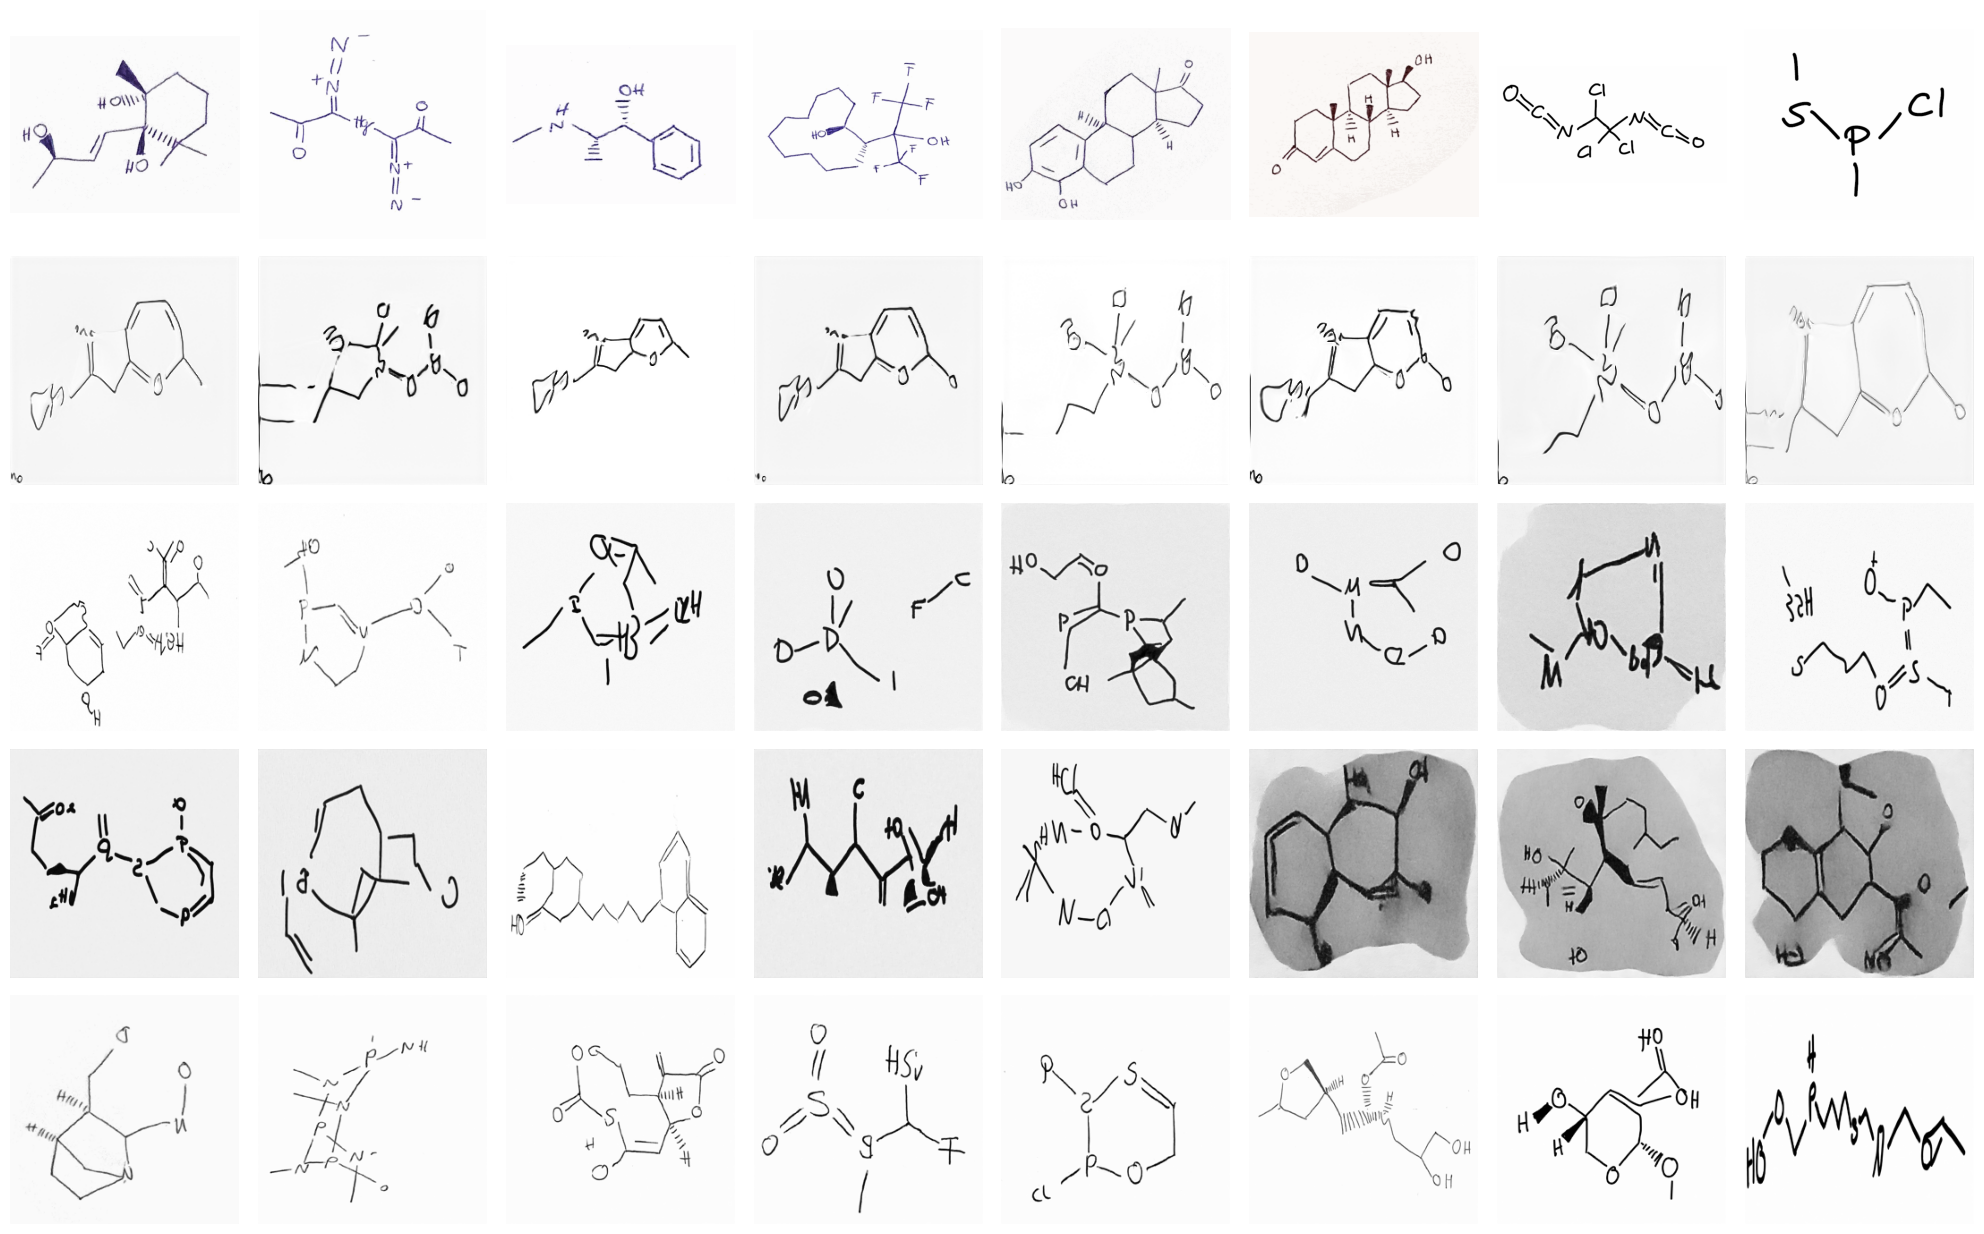

In [ ]:
n_col = 8
n_row = len(modelnames)

fig, ax = plt.subplots(n_row, n_col, figsize=(20,12.5))

for i, modelname in enumerate(modelnames):
        
    for j, idx in enumerate([1, 2, 3, 5, 7, 131, 237, 241]):
        
        img = images[modelname][idx]
        ax[i][j].imshow(img)
        ax[i][j].axis('off')
        #if j == 0:
            #ax[i][j].set_title(f"{modelname}", loc='left')
        
plt.tight_layout()
plt.show()

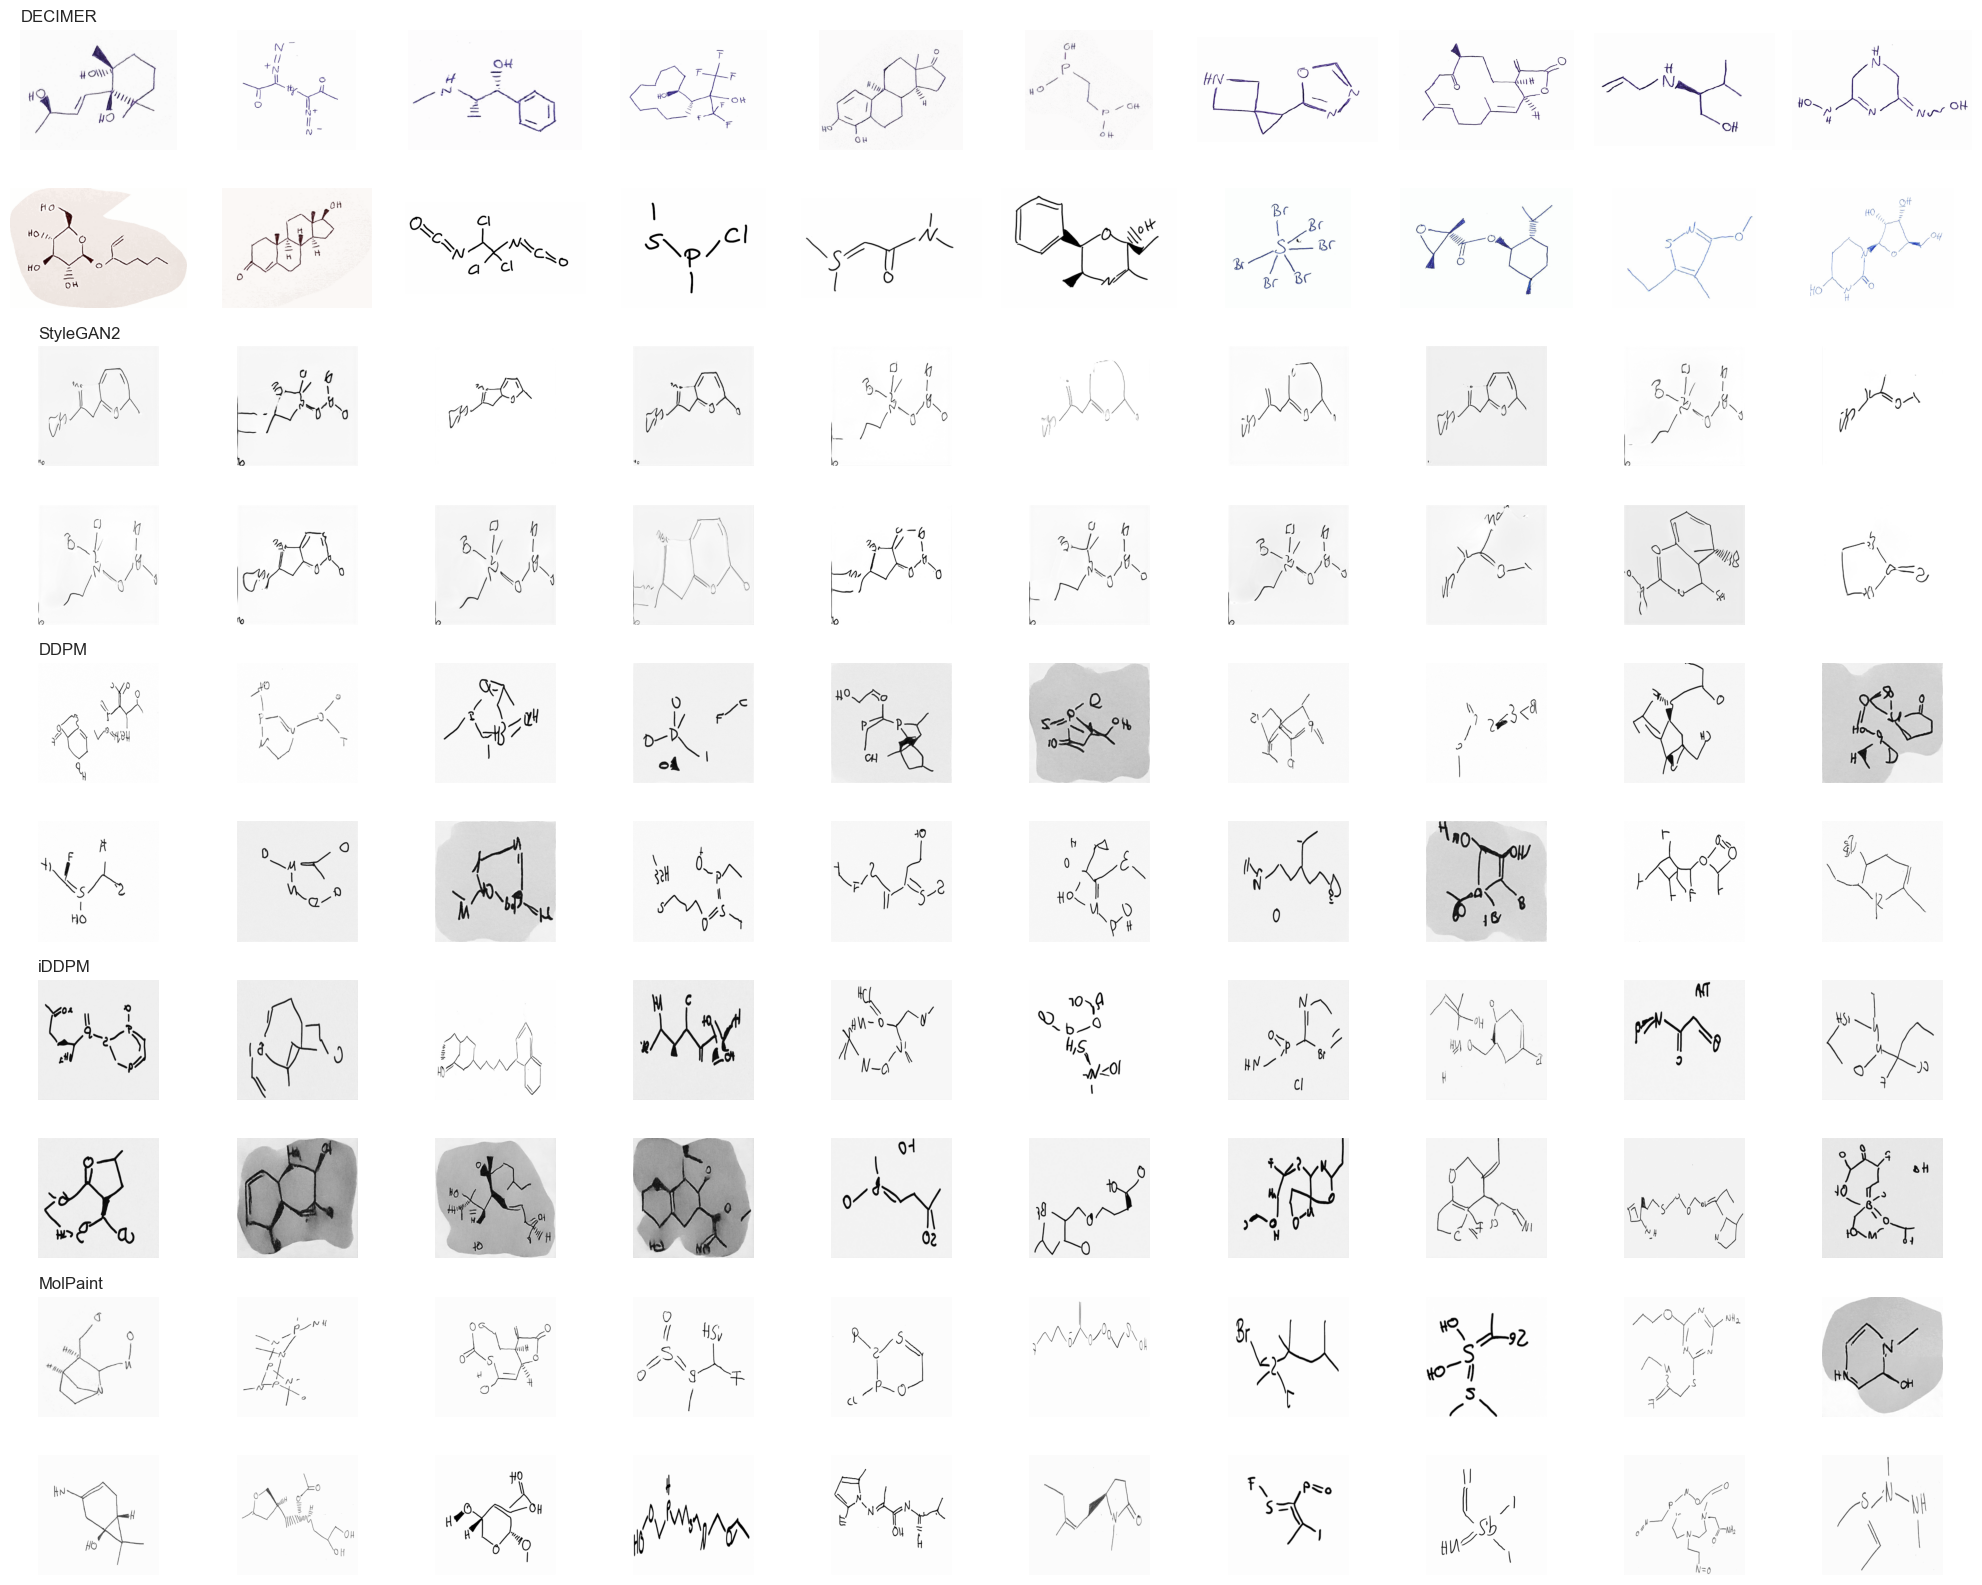

In [ ]:
n_col = 10
n_row = 10
offstr = n_row // len(modelnames)

fig, ax = plt.subplots(n_row, n_col, figsize=(20,16))

for i, modelname in enumerate(modelnames):
    
    i *= offstr
    
    for j, idx in enumerate([1, 2, 3, 5, 7, 11, 13, 17, 19, 23, 129, 131, 237, 241, 343, 347, 453, 459, 561, 567]):
        
        img = images[modelname][idx]
        ax[i+(j//n_col)][j%n_col].imshow(img)
        ax[i+(j//n_col)][j%n_col].axis('off')
        if j == 0:
            ax[i+(j//n_col)][j%n_col].set_title(f"{modelname}", loc='left')
        
plt.tight_layout()
plt.show()

## Image-to-vector using MolScribe

In [9]:
vectors = {}

for modelname in modelnames:
    outputs = molscribe.predict_features(images[modelname], batch_size=128, reduction='mean', use_tqdm=True)
    vectors[modelname] = np.array(outputs)
    print(f"[{modelname}] outputs.shape: {vectors[modelname].shape}")

/home/descartes/miniconda3/envs/molscribe/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:11<00:00,  3.28s/it]


[DECIMER] outputs.shape: (5088, 144)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.57s/it]


[StyleGAN2] outputs.shape: (1000, 144)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.58s/it]


[DDPM] outputs.shape: (1000, 144)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.58s/it]


[iDDPM] outputs.shape: (1000, 144)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.58s/it]

[MolPaint] outputs.shape: (1000, 144)


## FID : Frechet Inception Distance

In [10]:
# calculate frechet inception distance
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [22]:
scores = {}

CTRL = 'DECIMER'

for modelname in modelnames:
    if modelname != CTRL:
        scores[modelname] = calculate_fid(vectors[CTRL], vectors[modelname])
        
for k, v in scores.items():
    print(f"{k}\t{v:.3e}")

StyleGAN2	1.229e-03
DDPM	2.510e-04
iDDPM	1.867e-04
MolPaint	7.948e-05


## PCA : Principal Component Analysis

In [12]:
points = {}

#pca = PCA(n_components=2, random_state=2023).fit(np.concatenate(list(vectors.values())))
pca = UMAP(n_components=2, random_state=2023, verbose=True).fit(np.concatenate(list(vectors.values())))

for modelname in modelnames:
    points[modelname] = pca.transform(vectors[modelname])

UMAP(random_state=2023, verbose=True)
Fri Apr 14 13:43:23 2023 Construct fuzzy simplicial set
Fri Apr 14 13:43:23 2023 Finding Nearest Neighbors
Fri Apr 14 13:43:23 2023 Building RP forest with 10 trees
Fri Apr 14 13:43:23 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Fri Apr 14 13:43:30 2023 Finished Nearest Neighbor Search
Fri Apr 14 13:43:31 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Apr 14 13:43:46 2023 Finished embedding
Fri Apr 14 13:43:47 2023 Worst tree score: 0.48459507
Fri Apr 14 13:43:47 2023 Mean tree score: 0.49397007
Fri Apr 14 13:43:47 2023 Best tree score: 0.50682218
Fri Apr 14 13:43:48 2023 Forward diversification reduced edges from 136320 to 52822
Fri Apr 14 13:43:50 2023 Reverse diversification reduced edges from 52822 to 52822
Fri Apr 14 13:43:51 2023 Degree pruning reduced edges from 63250 to 62857
Fri Apr 14 13:43:51 2023 Resorting data and graph based on tree order
Fri Apr 14 13:43:51 2023 Building and compiling search function


Epochs completed:   0%|            0/100 [00:00]

Epochs completed:   0%|            0/100 [00:00]

Epochs completed:   0%|            0/100 [00:00]

Epochs completed:   0%|            0/100 [00:00]

Epochs completed:   0%|            0/100 [00:00]

In [13]:
frames = []

for modelname in modelnames:
    df = pd.DataFrame(points[modelname])
    df.columns = ['PC1', 'PC2']
    df.loc[:,'Label'] = modelname
    frames.append(df)

In [14]:
merged = pd.concat(frames)

In [15]:
merged

,PC1,PC2,Label
0,3.971335,4.461879,DECIMER
1,-1.995288,6.410282,DECIMER
2,1.285145,2.332839,DECIMER
3,1.139111,5.555433,DECIMER
4,-0.139114,2.583583,DECIMER
...,...,...,...
995,1.204094,4.218162,MolPaint
996,4.163343,3.598851,MolPaint
997,1.329098,4.097881,MolPaint
998,2.382556,5.466208,MolPaint


## Scatter plot

In [27]:
sns.set_theme(style='ticks')

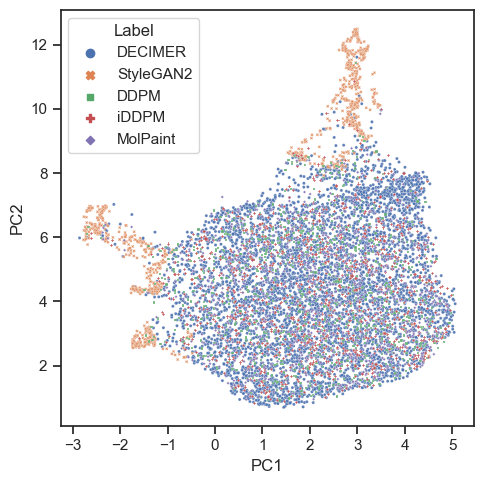

In [28]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

sns.scatterplot(data=merged, x='PC1', y='PC2', hue='Label', style='Label', alpha=0.9, s=5, ax=ax)

plt.tight_layout()
plt.show()